<a name='top'></a>    
<div style="width:900px;background:#fdf0db;border:1px solid black;text-align:left;padding:8px;">
    <p>
        <span style="font-size:14pt">
            <b>Prediction of Employee Turnover</b>
        </span>
    </p>
</div>

<div style="width:900px;background:#f2f2f2;border:1px solid black;text-align:left;padding:8px;"><b>
    
    
## Notebook Outline ##    
1. [Introduction](#intro)    

2. [User Defined Functions](#udf)    
2.1. [plot_2d_space](#udf1)    
2.2. [bar_graph_bycount](#udf2)    
2.3. [plot_conf_matrix_and_roc](#udf3)    
2.4. [print_mod_10fold_CV_f1_score](#udf4)    
2.5. [plot_roc](#udf5)    

3. [Data Analysis](#data)    
3.1. [Data Preprocessing](#data0)    
3.2. [Data Processing](#data1)    

4. [EDA](#eda)    
4.1. [Employees Left Feature](#eda1)    
4.2. [Number of Projects Feature](#eda2)    
4.3. [Time Spent in Company Features](#eda3)    
4.3. [Salary Levels](#eda4)    
4.3. [Satisfaction Levels](#eda5)    
4.4. [Other Features](#eda6)    
4.5. [Data Analysis and Visualization Summary](#edasum)    

5. [Balanced vs Imbalanced Dataset](#mod1)    
5.1. [PCA on Training Data](#mod2)     

6. [Modeling](#mod)    
6.1. [Methodology in Building Classifiers](#modmeth)     
6.2. [Random Forest Classifier (RFC)](#mod3)     
6.2.1. [Random Forest with Upsampling Data](#mod3a)     
6.3. [Gradient Boosting Trees](#mod4)    
6.4. [K-Nearest Neighbors](#mod5)    
6.5. [Logistic Regression](#mod6)    
6.6. [Support Vector Machine (SVM)](#mod7)    
6.7. [Evaluate Model Results](#mod8)    

7. [Summary & Conclusion](#summary) 



<a name='intro'>

### Introduction 

**Employee turnover**, or **staff turnover**, is a measurement of how many employees are leaving a company. It’s a way to track whether a company has more employees leaving than is typically expected. This includes employees that either quit, were let go, or retired. However, companies that measure their employee turnover often separate these to manage each type of turnover.

It is very costly for organizations, where costs include but not limited to: separation, vacancy, recruitment, training and replacement. On average, organizations invest between four weeks and three months training new employees. This investment would be a loss for the company if the new employee decided to leave the first year. Furthermore, we can also factor the cost of hiring for that position, any severance or bonus packages, and managing the role when it is not filled.  Organizations such as consulting firms would suffer from deterioration in customer satisfaction due to regular changes in Account Reps and/or consultants that would lead to loss of businesses with clients.  

Thus, every organization should strive to retain their employees for as long as possible. If they see a uptick in employee turnover, then they should take action to reduce turnover and improve retention. This results in more efficient operations, higher morale, and higher profits.

## The Data
In this notebook we will use a simulated HR data from [kaggle](https://www.kaggle.com/liujiaqi/hr-comma-sepcsv) to build a classifier that helps us predict what kind of employees would likely to leave based on given attributes.  These classifiers will help an organization predict employee turnover and will enable them to become pro-active in helping to address this ongoing problem.

The data has 14,999 examples (samples). Below are the features and the definitions of each one:
- **satisfaction_level**: Level of satisfaction {0-1}.
- **last_evaluationTime**: Time since last performance evaluation (in years).
- **number_project**: Number of projects completed while at work.
- **average_montly_hours**: Average monthly hours at workplace.
- **time_spend_company**: Number of years spent in the company.
- **Work_accident**: Whether the employee had a workplace accident.
- **left**: Whether the employee left the workplace or not {0, 1}.
- **promotion_last_5years**: Whether the employee was promoted in the last five years.
- **sales**: Department the employee works for.
- **salary**: Relative level of salary {low, medium, high}.

Let's first load all the packages.

In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             roc_auc_score,
                             roc_curve,
                             confusion_matrix)
from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     learning_curve,
                                     validation_curve,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from warnings import filterwarnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_context("notebook")
plt.style.use("fivethirtyeight")
filterwarnings("ignore")

<div style="width:610px;background:#fdf0db;border:1px solid black;
  text-align:left;padding:8px;"><b>
<h7><a name='udf'><font color=black>User Defined Functions  
    </a></h7></b>    
</div>

Let us create a some User Defined functions to before proceeding with the Data Analysis.  Click [Here](#eda) to Proceed Directly to EDA Analysis. 

<a style='color:black; font-weight:bold' name='udf1'>
plot_2d_space </a>

In [2]:
## Put Description Here
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

<a style='color:black; font-weight:bold' name='udf2'>
bar_graph_bycount </a>

In [3]:
## Generate a bar graph to show distribution of a certain field.
def bar_graph_bycount(field1,field2,xlabel='',ylabel='',title=''):
    num_projects=df.groupby(field1).count()
    plt.bar(num_projects.index.values, num_projects[field2])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

<a style='color:black; font-weight:bold' name='udf3'>
plot_conf_matrix_and_roc </a>

In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, roc_curve


def plot_conf_matrix_and_roc(estimator, X, y, figure_size=(16, 6)):
    """
    Plot both confusion matrix and ROC curce on the same figure.

    Parameters:
    -----------
    estimator : sklearn.estimator
        model to use for predicting class probabilities.
    X : array_like
        data to predict class probabilities.
    y : array_like
        true label vector.
    figure_size : tuple (optional)
        size of the figure.

    Returns:
    --------
    plot : matplotlib.pyplot
        plot confusion matrix and ROC curve.
    """
    # Compute tpr, fpr, auc and confusion matrix
    fpr, tpr, thresholds = roc_curve(y, estimator.predict_proba(X)[:, 1])
    auc = roc_auc_score(y, estimator.predict_proba(X)[:, 1])
    conf_mat_rf = confusion_matrix(y, estimator.predict(X))

    # Define figure size and figure ratios
    plt.figure(figsize=figure_size)
    gs = GridSpec(1, 2, width_ratios=(1, 2))

    # Plot confusion matrix
    ax0 = plt.subplot(gs[0])
    ax0.matshow(conf_mat_rf, cmap=plt.cm.Reds, alpha=0.2)

    for i in range(2):
        for j in range(2):
            ax0.text(x=j, y=i, s=conf_mat_rf[i, j], ha="center", va="center")
    plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
    plt.xlabel("Predicted", fontdict={"fontsize": 14})
    plt.ylabel("Actual", fontdict={"fontsize": 14})


    # Plot ROC curce
    ax1 = plt.subplot(gs[1])
    ax1.plot(fpr, tpr, label="auc = {:.3f}".format(auc))
    plt.title("ROC curve", y=1, fontdict={"fontsize": 20})
    ax1.plot([0, 1], [0, 1], "r--")
    plt.xlabel("False positive rate", fontdict={"fontsize": 16})
    plt.ylabel("True positive rate", fontdict={"fontsize": 16})
    plt.legend(loc="lower right", fontsize="medium");

<a style='color:black; font-weight:bold' name='udf4'>
print_mod_10fold_CV_f1_score </a>

In [5]:
def print_mod_10fold_CV_f1_score(model):
    '''
    Print 10 folds CV f1-score of model
    
    '''
    print("\033[1m" + "\033[0m" + "The best hyperparameters:")
    print("-" * 25)
    for hyperparam in model.best_params_.keys():
        print(hyperparam[hyperparam.find("__") + 2:], ": ", model.best_params_[hyperparam])

    print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((model.best_score_) * 100))
    print()

<a style='color:black; font-weight:bold' name='udf5'>
plot_roc() </a>

In [6]:
def plot_roc(estimators, X, y, figure_size=(16, 6)):
    """
    Plot both confusion matrix and ROC curve on the same figure.

    Parameters:
    -----------
    estimators : dict
        key, value for model name and sklearn.estimator to use for predicting
        class probabilities.
    X : array_like
        data to predict class probabilities.
    y : array_like
        true label vector.
    figure_size : tuple (optional)
        size of the figure.

    Returns:
    --------
    plot : matplotlib.pyplot
        plot confusion matrix and ROC curve.
    """
    plt.figure(figsize=figure_size)
    for estimator in estimators.keys():
        # Compute tpr, fpr, auc and confusion matrix
        fpr, tpr, thresholds = roc_curve(y, estimators[estimator].predict_proba(X)[:, 1])
        auc = roc_auc_score(y, estimators[estimator].predict_proba(X)[:, 1])

        # Plot ROC curve
        plt.plot(fpr, tpr, label="{}: auc = {:.3f}".format(estimator, auc))
        plt.title("ROC curve", y=1, fontdict={"fontsize": 20})
        plt.legend(loc="lower right", fontsize="medium")

    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False positive rate", fontdict={"fontsize": 16})
    plt.ylabel("True positive rate", fontdict={"fontsize": 16});

[Go Top](#top)
<a style='color:black; font-weight:bold' name='data'>

<div style="width:610px;background:#fdf0db;border:1px solid black;
  text-align:left;padding:8px;"><b>
<a style='color:black; font-weight:bold' name='data0'>
Data Preprocessing </a>   
</div>
We will do some data insights and check if our data has missing or null values

In [7]:
## Load Data
file='HR_comma_sep.csv'

df = pd.read_csv(file, encoding='latin1')
df.shape

(14999, 10)

In [8]:
## check for null
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [9]:
## Check datype of every feature
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

**Findings:**<br>
<i>No missing values and No Null values found in data.

<b>[Go Top](#top)

<div style="width:610px;background:#fdf0db;border:1px solid black;
  text-align:left;padding:8px;"><b>
<h7><a name='data1'><font color=black>Data Processing  
    </a></h7></b>    
</div>

Since there were no null or missing values, no need to do any imputations.
However, some data processing was performed:
1. Renamed **sales** feature to **department**.
2. Create dummy features from **department** and drop the **deparment** feature to avoid linear dependency.
3. Convert **salary** into ordinal categorical feature (low:0, medium:1, high:2)

| Feature | Description  |
|------|------|
|satisfaction_level     |Level of satisfaction {0–1}.
|last_evaluationTime    |Time since last performance evaluation (in years).
|number_project         |Number of projects completed while at work.
|average_montly_hours   |Average monthly hours at workplace.
|time_spend_company     |Number of years spent in the company.
|Work_accident          |Whether the employee had a workplace accident.
|left                   |Whether the employee left the workplace or not {0, 1}.
|promotion_last_5years  |Whether the employee was promoted in the last five years.
|department (**a.k.a. sales**)                  |Department the employee works for.
|salary                 |Relative level of salary {low, medium, high}.

<b><h7><a name='data1a'><font color=black>Department (renamed from sales feature)
    </a></h7></b>    
</div>

In [10]:
## Rename sales feature into department for 
df=df.rename(columns={'sales':'department'})

In [11]:
## Save Department Feature to a list.  This will be used for EDA later.
department_list=df.department

In [12]:
## Create dummy variables for department
df=pd.get_dummies(df,columns=['department'], drop_first=True)
[col for col in df if col.startswith('department')]

['department_RandD',
 'department_accounting',
 'department_hr',
 'department_management',
 'department_marketing',
 'department_product_mng',
 'department_sales',
 'department_support',
 'department_technical']

<b><h7><a name='data1b'><font color=black>Salary
    </a></h7></b>    
<i>Map each value of Salary to a number (e.g. low:0, medium:1, high:2) 

In [13]:
print('Before Update:')
df.salary.value_counts()

Before Update:


low       7316
medium    6446
high      1237
Name: salary, dtype: int64

In [14]:
## Map Salary into integers
salary_map={'low':0, 'medium':1, 'high':2}
df['salary']=df['salary'].map(salary_map)

df.salary.value_counts()

0    7316
1    6446
2    1237
Name: salary, dtype: int64

<b>[Go Top](#top)

We will now proceed to EDA for further analysis our features

<div style="width:610px;background:#fdf0db;border:1px solid black;
  text-align:left;padding:8px;"><b>
<h7><a name='eda'><font color=black>EDA (Exploratory Data Analysis)
    </a></h7></b>    
</div>

In [15]:
[col for col in df if col.startswith('department')==False]

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'left',
 'promotion_last_5years',
 'salary']

<b><h7><a name='eda1'><font color=black>Employees Left Feature
    </a></h7></b>    
We need to check the proportion of each class of this feature to see if we are dealing with `balanced` or `imbalanced` data.

In [16]:
## Extract percent of those that left and stayed
val=df['left'].value_counts(normalize=True).mul(100)
print('Percentage of those that left  : {:.2f}%'.format(val[1]))
print('Percentage of those that stayed: {:.2f}%'.format(val[0]))

Percentage of those that left  : 23.81%
Percentage of those that stayed: 76.19%


In [17]:
## Extract number of positive and negative examples
pos=df[df['left']==1].shape[0]
neg=df[df['left']==0].shape[0]
print('Those that left  : {}'.format(pos))
print('Those that stayed: {}'.format(neg))
print('Proportion of positive to negative examples: {:.2f}%'.format((pos / neg) * 100))

Those that left  : 3571
Those that stayed: 11428
Proportion of positive to negative examples: 31.25%


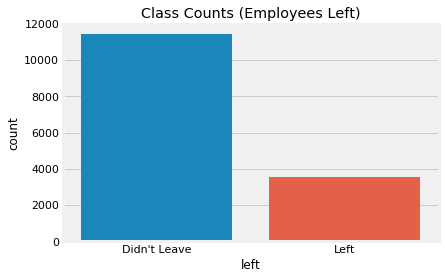

In [18]:
sns.countplot(df['left'])
plt.xticks((0,1),["Didn't Leave",'Left'])
plt.title('Class Counts (Employees Left)');

In [19]:
## 23.81% of the employees left the company.
## Proportion of positive to negative examples: 31.25%

We have verified that we are dealing with `imbalanced dataset`.   We will touch more on this later and continue on with our EDA.

<b><h7><a name='eda2'><font color=black>Number of Projects
    </a></h7></b>    
Let us check on the distribution on the number of projects  

In [20]:
df.number_project.value_counts()

4    4365
3    4055
5    2761
2    2388
6    1174
7     256
Name: number_project, dtype: int64

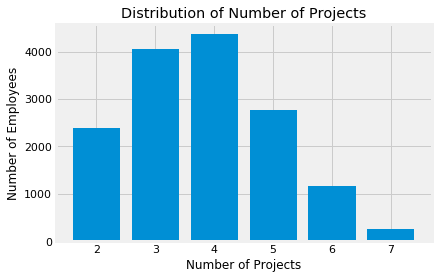

In [21]:
bar_graph_bycount('number_project',
                  'satisfaction_level',
                  'Number of Projects',
                  'Number of Employees',
                  'Distribution of Number of Projects')

In [22]:
## Findings, Most Employees have done 3-5 Projects.

<b><h7><a name='eda3'><font color=black>Time Spent in Company
    </a></h7></b>    

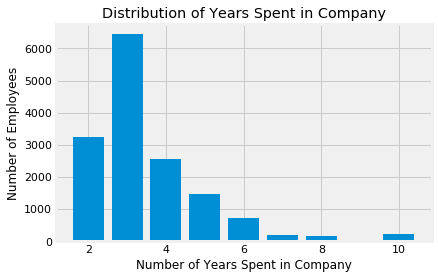

In [23]:
bar_graph_bycount('time_spend_company', #Main Feature 
                  'satisfaction_level', 
                  'Number of Years Spent in Company', #X Label
                  'Number of Employees',  # Y Label
                  'Distribution of Years Spent in Company')  #Title 

In [24]:
## Findings:  
findings='''
1. Majority of Employees have 2-4 Years of Experience.   
2. There is a Major gap between Employees of 3 to 4 years.
3. Only few Employees are left with 8 years and above 
   (as compared to those with 2-4 years experience)   
'''

In [25]:
df.time_spend_company.value_counts().sort_values(ascending=True)

8      162
7      188
10     214
6      718
5     1473
4     2557
2     3244
3     6443
Name: time_spend_company, dtype: int64

<b><h7><a name='eda4'><font color=black>Salary Levels
</a></h7></b><br> 
We want to check the salary of those that have left and have stayed behind

In [84]:
df.left.value_counts()

0    11428
1     3571
Name: left, dtype: int64

In [80]:
val=df.groupby(['salary','left'])['salary'].count()
print(val)
#print(df.salary.value_count)
#df['salary'].value_counts()
df.salary.value_counts()

salary  left
0       0       5144
        1       2172
1       0       5129
        1       1317
2       0       1155
        1         82
Name: salary, dtype: int64


0    7316
1    6446
2    1237
Name: salary, dtype: int64

<Figure size 1080x504 with 0 Axes>

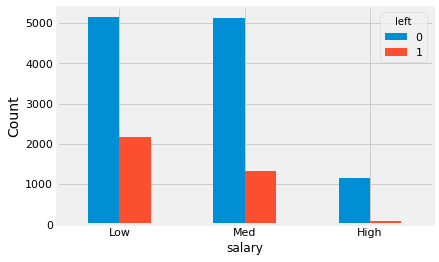

In [27]:
fig = plt.figure(figsize=(15,7))
pd.crosstab(df.salary, df.left).plot(kind='bar')
plt.xticks((0,1,2),["Low",'Med','High'])
plt.xticks(rotation=0)
plt.ylabel("Count", {"fontsize": 14})
plt.show()

Based on graph above, most of the employees that left had low and medium salary ranges.  Those that had higher salary stayed.

<b><h7><a name='eda5'><font color=black>Satisfaction Level

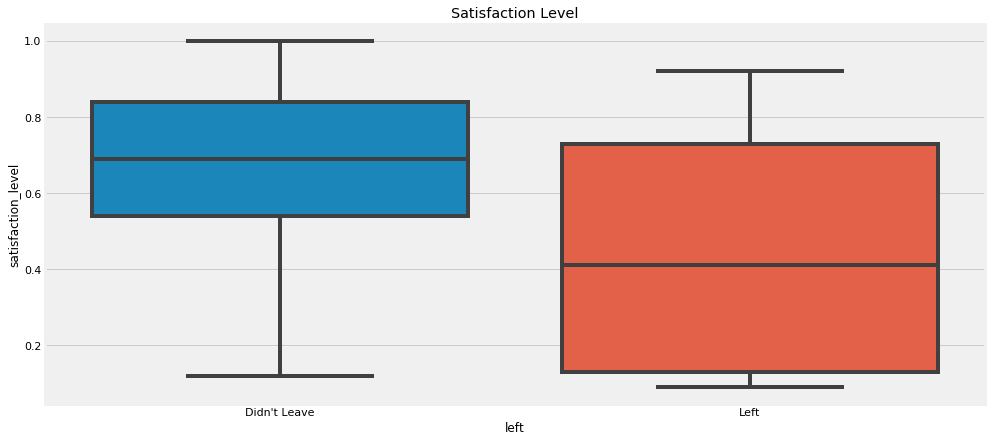

In [86]:
fig = plt.figure(figsize=(15,7))
sns.boxplot(x="left", y= "satisfaction_level", data=df)
plt.xticks((0,1),["Didn't Leave",'Left'])
plt.title('Satisfaction Level')
plt.show()

<b><h7><a name='eda6'><font color=black>Evaluating Other Features
    </a></h7></b>    

In [29]:
#features=[col for col in df if col.startswith('department')==False]
features=['number_project',
 'time_spend_company',
 'Work_accident',
 'left',
 'promotion_last_5years',
 'salary']

In [30]:
df.salary.value_counts()

0    7316
1    6446
2    1237
Name: salary, dtype: int64

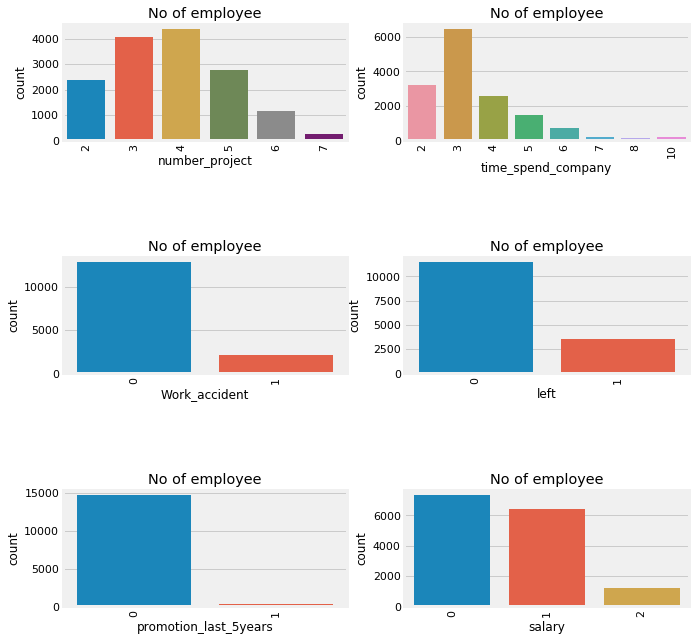

In [31]:
fig=plt.subplots(figsize=(10,15))
#fig=plt.subplots(figsize=(10,20))
for i,j in enumerate(features):
    plt.subplot(4,2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j, data=df)
    plt.xticks(rotation=90)
    plt.title('No of employee')

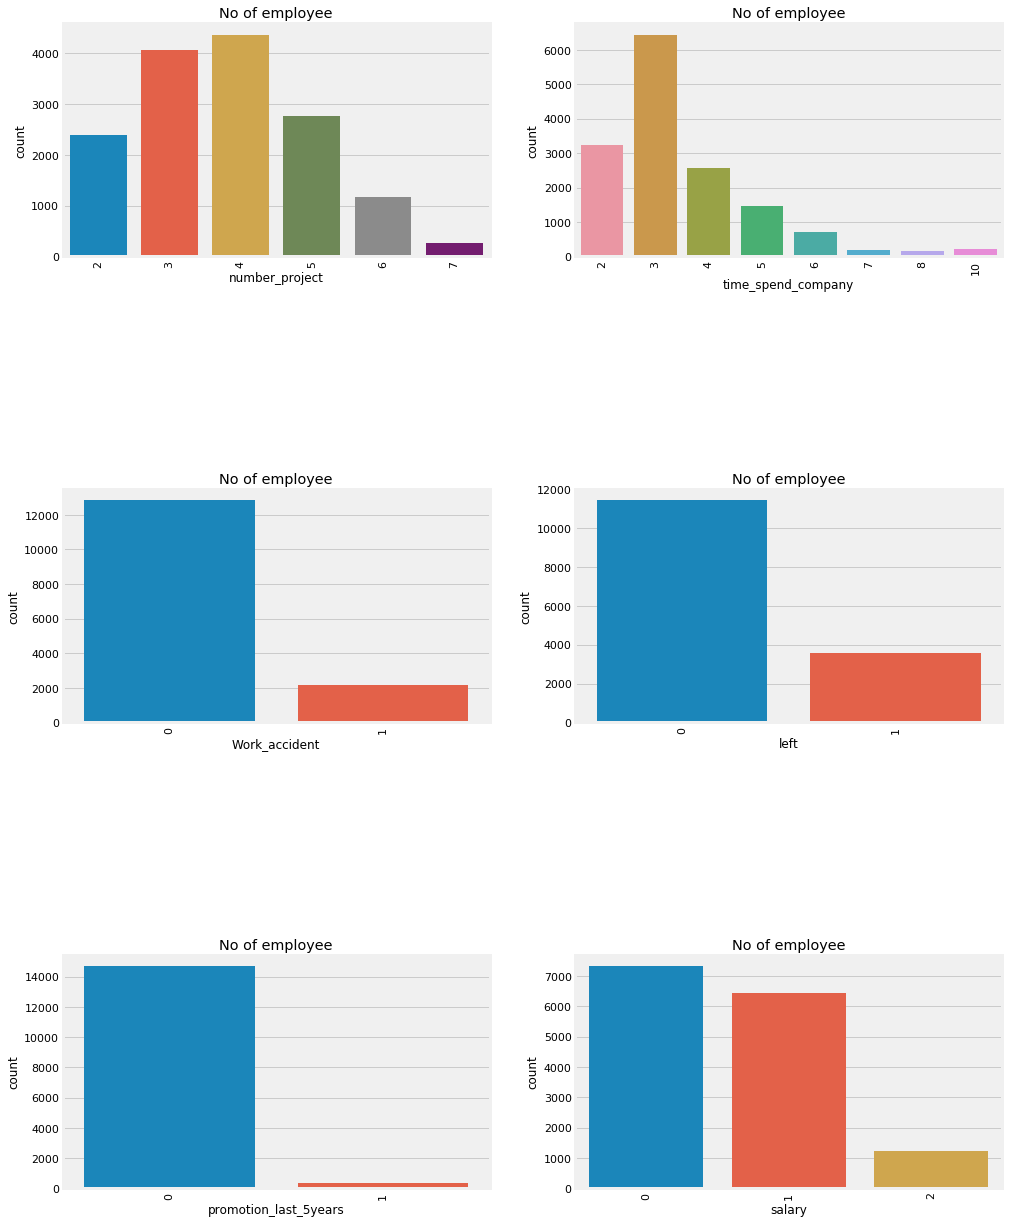

In [56]:
## raj to be deleted later
fig=plt.subplots(figsize=(15,30))
#fig=plt.subplots(figsize=(15,30))
for i,j in enumerate(features):
    plt.subplot(4,2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j, data=df)
    plt.xticks(rotation=90)
    plt.title('No of employee')

In [32]:
## Findings based on Visualization:
comments='''

- Those employees who have the number of projects more than 5 were left the company.
- The employee who had done 6 and 7 projects, left the company it seems to like 
      that they were overloaded with work.
- The employee with five-year experience is leaving more because of no promotions 
      in last 5 years and more than 6 years experience are not leaving because of 
      affection with the company.
- Those who promotion in last 5 years they didn't leave, i.e., all those left they 
      didn't get the promotion in the previous 5 years.

'''

<b><h7><a name='edasum'><font color=black>Data Analysis and Visualization Summary
</a></h7></b> 
- `Promotions`: Employees are far more likely to quit their job if they haven't received a promotion in the last 5 years.
- `Time with Company`: Here, The three-year mark looks like a time to be a crucial point in an employee's career. Most of them quit their job around the three-year mark. Another important point is 6-years point, where the employee is very unlikely to leave.
- `Number Of Projects`: Employee engagement is another critical factor to influence the employee to leave the company.  Employees with 3-5 projects are less likely to leave the company. The employee with less and more number of projects are likely to leave.
- `Salary`: Most of the employees that quit among the mid or low salary groups.
- `Left`: From our plotted graph, most of the employees have already quit the company (31.25% still remained)
    
In a nutshell, based on the historical data, HR needs to be wary of employees with `low/medium salary` that are going in their `3rd year tenure`.  These employees Usually have worked with `3-5 projects` ahd `hasn't been promoted` yet.

These employees are more likely to quit or resign their jobs.

<br>[Go Top](#top)

<b><h7><a name='eda5'><font color=black>Evaluating Information of those that have left
</a></h7></b>    
Just added a few more graphs to take a look at the data of those that have already left the company    

In [33]:
#raj

In [34]:
## Copy dataframe to df2 and include department feature to be used in EDA.
df2=df;
df2['department']=department_list

In [35]:
## Extract records of those that have left the company.
df2_left=df2[df['left']==1]

<b><h7><a name='eda6'><font color=black>Employees that left in each Department
</a></h7></b>    

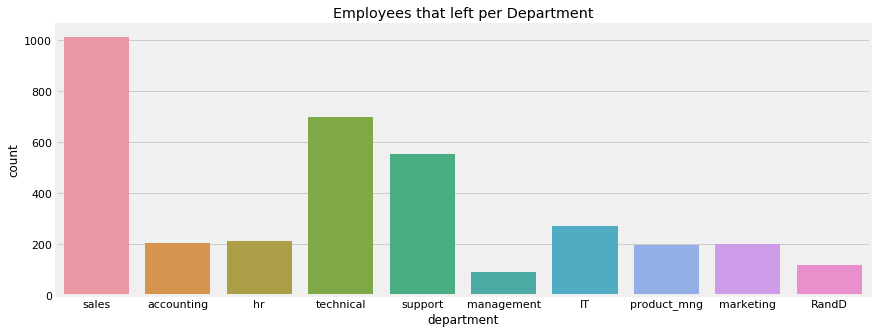

In [36]:
## Employees that left in each Department
fig = plt.figure(figsize=(13,5))
sns.countplot(x='department',data=df2_left)
plt.title('Employees that left per Department')
plt.show()

Based on the Graph, Sales Department has the most Employees, Followed by technical, support, then IT Department

<b><h7><a name='eda7'><font color=black>Salary Distribution of those that Left
</a></h7></b>    

salary
0    2172
1    1317
2      82
Name: left, dtype: int64


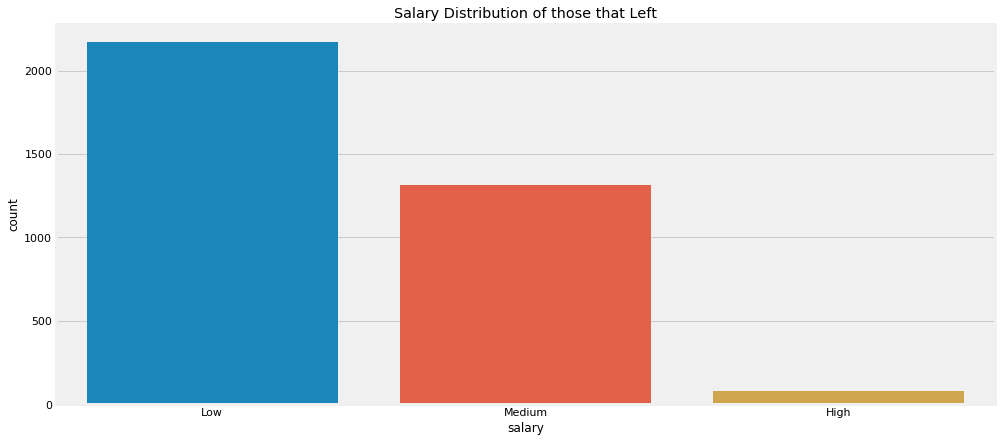

In [37]:
print(df2_left.groupby('salary').sum()['left'])
df = df.drop('department', axis=1)

fig = plt.figure(figsize=(15,7))
sns.countplot(x='salary',data=df2_left)
plt.xticks((0,1,2),["Low",'Medium','High'])
plt.title('Salary Distribution of those that Left')
plt.show()

Based on the graph above, Majority of the People that left had low salaries(2,172).  

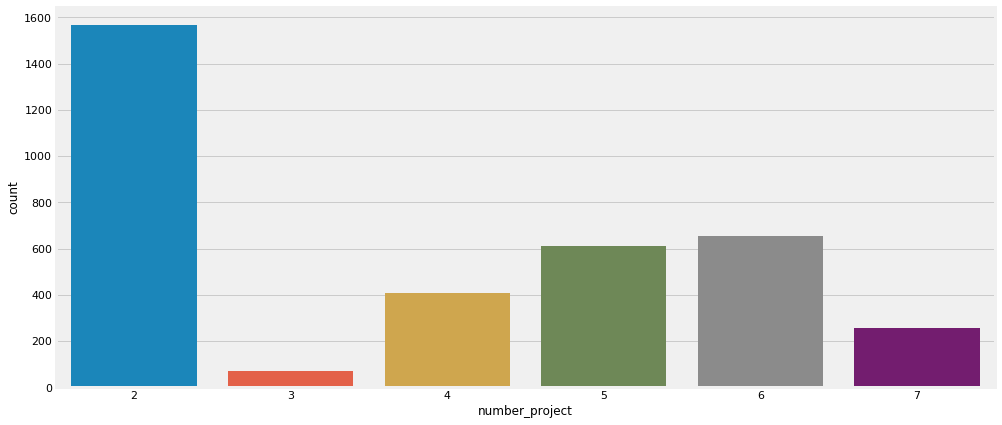

In [38]:
fig = plt.figure(figsize=(15,7))
sns.countplot(x='number_project',data=df2_left)
plt.show()
#rajtest

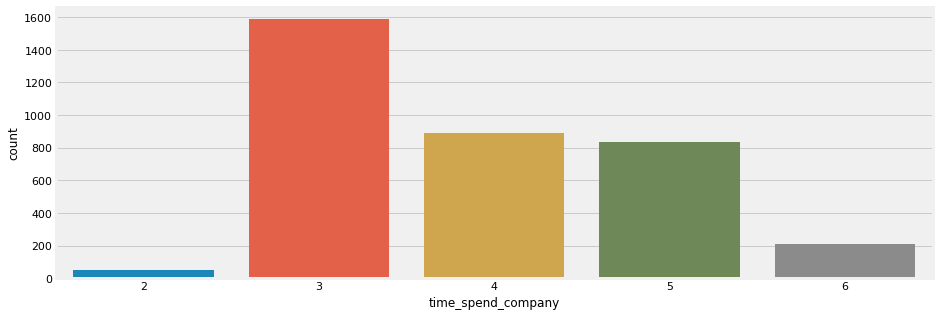

In [39]:
fig = plt.figure(figsize=(14,5))
sns.countplot(x='time_spend_company',data=df2_left)
plt.show()

<a name='eda'>

[Go Top](#top)

<div style="width:610px;background:#fdf0db;border:1px solid black;
  text-align:left;padding:8px;"><b>
<h7><a name='mod'><font color=black>Modeling
    </a></h7></b>    
</div>

<a style='color:black; font-weight:bold' name='mod1'>
Balanced vs Inbalanced Dataset </a>

Let's visit again our analysis of the proportion of each class for the feature **left** to see if we are dealing with ***balanced*** or ***imbalanced*** data.

In [40]:
## Extract number of positive and negative examples
pos=df[df['left']==1].shape[0]
neg=df[df['left']==0].shape[0]
print('Those that left  : {}'.format(pos))
print('Those that stayed: {}'.format(neg))
print('Proportion of positive to negative examples: {:.2f}%'.format((pos / neg) * 100))
print('-----------------------------------------')

## Extract percent of those that left and stayed
val=df['left'].value_counts(normalize=True).mul(100)
print('Percentage of those that left  : {:.2f}%'.format(val[1]))
print('Percentage of those that stayed: {:.2f}%'.format(val[0]))

Those that left  : 3571
Those that stayed: 11428
Proportion of positive to negative examples: 31.25%
-----------------------------------------
Percentage of those that left  : 23.81%
Percentage of those that stayed: 76.19%


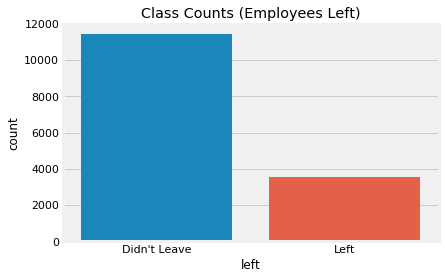

In [41]:
sns.countplot(df['left'])
plt.xticks((0,1),["Didn't Leave",'Left'])
plt.title('Class Counts (Employees Left)');

Based on the above graph, we are dealing with an **imbalanced dataset**.  (Proportion of positive to negative examples is **31.25%**)  As a result, when we fit classifiers on such datasets, we should use metrics other than accuracy when comparing models such as f1-score or AUC.  

Moreover, class imbalance influences a learning algorithm during training by making the decision rule biased towards the majority class by implicitly learning a model that optimizes the predictions based on the majority class in the dataset.  We can deal with this issue in 3 ways:
1. Assign a larger penalty to wrong predictions from the minority class.
2. Upsampling the minority class or downsampling the majority class.
3. Generate synthetic training examples.

Nonetheless, there is no definitive guide or best practices to deal with such situations. Therefore, we have to try them all and see which one works better on the problem at hand. We'll restrict ourselves to use the first two, i.e assign larger penalty to wrong predictions from the minority class using `class_weight` in classifiers that allows us do that and evaluate upsampling/downsampling on the training data to see which gives higher performance.

In [42]:
# Convert dataframe into numpy objects and split them into
# train and test sets: 80/20
X = df.loc[:, df.columns != "left"].values
y = df.loc[:, df.columns == "left"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)
X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))

# Downsample majority class
X_train_d, y_train_d = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=1)
X_train_d = np.concatenate((X_train[y_train == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))

print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)
print("Downsampled shape:", X_train_d.shape, y_train_d.shape)

Original shape: (11999, 17) (11999,)
Upsampled shape: (18284, 17) (18284,)
Downsampled shape: (5714, 17) (5714,)


<b>
<h7><a name='mod2'><font color=black>PCA and Dimensionality Reduction
    </a></h7></b><br>    

It seems we won't need to apply dimensionality reduction such as PCA because:
1. We want to know the importance of each feature in determining who will leave vs who won't (inference). 
2. Dimension of the dataset is descent (17 features). However, it's good to see how many principal components needed to explain 90%, 95% and 99% of the variation in the data.

In [43]:
## Build PCA using standardized trained data
pca=PCA(n_components=None, svd_solver='full')
pca.fit(StandardScaler().fit_transform(X_train))
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)

cum_var_exp

array([0.1078147 , 0.18756726, 0.26523205, 0.33604446, 0.4036422 ,
       0.46807506, 0.53094596, 0.59334034, 0.65535106, 0.71691288,
       0.77413324, 0.82651546, 0.87672244, 0.92515346, 0.96216602,
       0.99429813, 1.        ])

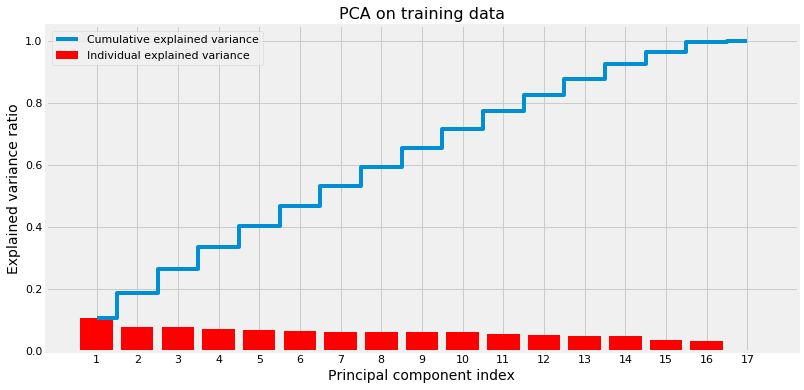

In [44]:
plt.figure(figsize=(12, 6))
plt.bar(range(1, 18), pca.explained_variance_ratio_, align="center",
        color='red', label="Individual explained variance")
plt.step(range(1, 18), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.xticks(range(1, 18))
plt.legend(loc="best")
plt.xlabel("Principal component index", {"fontsize": 14})
plt.ylabel("Explained variance ratio", {"fontsize": 14})
plt.title("PCA on training data", {"fontsize": 16});

Looks like it needs 14, 15 and 16 principal components to capture 90%, 95% and 99% of the variation in the data respectively. In other words, this means that the data is already in a good space since eigenvalues are very close to each other and gives further evidence that we don't need to compress the data.


In [46]:
# raj to be removed later...
#df = df.drop('area', axis=1)

<div style="width:610px;background:#fdf0db;border:1px solid black;
  text-align:left;padding:8px;"><b>
<h7><a name='mod'><font color=black>
    </a></h7></b>    
</div>

<a style='color:black; font-weight:bold' name='modmeth'>
Methodology in Building Classifiers</a>

The methodology used in building the classifiers are:
1. Build a pipeline that handles all the steps when fitting the classifier using `make_pipeline` which has 2 substeps:
    1. Standardize the data to make all the features on the same scale.
    2. The classifier (`estimator`) we want to use to fit the model.
2. Use `GridSearchCV` to tune the hyperparameters using 10-folds cross validations.  We can use `RandomizedSearchCV` which is faster and may outperform `GridSearchCV` especially if we have more than two hyperparameters and the range for each one is very big; however, `GridSearchCV` will work just fine since we have only two hyperparameters and descent range.
3. Fit the model using training data.
4. Plot both confusion matrix and ROC curve for the best estimator using test data.

We will apply the same steps above for *Random Forest, Gradient Boosting Trees, K-Nearest Neighbors, Logistic Regression and Support Vector Machine*. Afterwards, compare each classifier and pick the one that has the highest cross validation f1 score. 

Note that some of the hyperparameter ranges will be guided by the paper [Data-driven Advice for Applying Machine Learning to Bioinformatics Problems](https://arxiv.org/pdf/1708.05070.pdf).

<a style='color:black; font-weight:bold' name='mod3'>
Random Forest </a>

1. We will start by fitting a Random Forest Classifer using unsampled(original), upsampled and downsampled data.
2. We will then evaluate each method using cross validation (CV) f1-score and pick the one with the highest CV f1-score.
3. Finally, we will use the the best method to fit the rest of the classifiers.

The only hyperparameters we'll tune are:
- `max_feature`: how many features to consider randomly on each split. This will help avoid having few strong features to be picked on each split and let other features have the chance to contribute. Therefore, predictions will be less correlated and the variance of each tree will decrease.
- `min_samples_leaf`: how many examples to have for each split to be a final leaf node.

Random Forest is an ensemble model that has multiple trees (`n_estimators`), where each tree is a weak learner. The final prediction would be a weighting average or mode of the predictions from all estimators. Note: high number of trees don't cause overfitting.

In [47]:
## Build Random Forest Classifier
methods_data = {'Original':(X_train,y_train),
                'Upsampled':(X_train_u,y_train_u),
                'Downsampled':(X_train_d,y_train_d)}

for method in methods_data.keys():
    pip_rf = make_pipeline(StandardScaler(),
                           RandomForestClassifier(n_estimators=500,
                                                  class_weight='balanced',
                                                  random_state=123))
    hyperparam_grid = {
        'randomforestclassifier__n_estimators': [10,50,100,500],
        'randomforestclassifier__max_features': ['sqrt','log2',0.4,0.5],
        'randomforestclassifier__min_samples_leaf': [1,3,5],
        'randomforestclassifier__criterion': ['gini','entropy']        
    }                           
    
    gs_rf = GridSearchCV(pip_rf,
                         hyperparam_grid,
                         scoring='f1',
                         cv=10,
                         n_jobs=-1)
    
    gs_rf.fit(methods_data[method][0], methods_data[method][1])
    
    print()
    print('\033[1m'+'\033[94m'+'(',method,'Data )')
    print_mod_10fold_CV_f1_score(gs_rf)


( Original Data )
The best hyperparameters:
-------------------------
criterion :  gini
max_features :  0.5
min_samples_leaf :  1
n_estimators :  500
Best 10-folds CV f1-score: 98.19%.


( Upsampled Data )
The best hyperparameters:
-------------------------
criterion :  entropy
max_features :  0.4
min_samples_leaf :  1
n_estimators :  50
Best 10-folds CV f1-score: 99.80%.


( Downsampled Data )
The best hyperparameters:
-------------------------
criterion :  entropy
max_features :  0.4
min_samples_leaf :  1
n_estimators :  500
Best 10-folds CV f1-score: 98.42%.



Upsampling yielded the highest CV f1-score with **99.80%**. 
Therefore, we'll be using the upsampled data to fit the 
rest of the classifiers. The new data now has 18,284 
examples with 50% of the examples belong to the positive 
class and the other 50% belong to the negative class.

In [87]:
print('Upsample Minority Class:',X_train_u[y_train_u == 0].shape, X_train_u[y_train_u == 1].shape)

Upsample Minority Class: (9142, 17) (9142, 17)


<a style='color:black; font-weight:bold' name='mod3a'>
Random Forest with Upsampling data</a>

We will refit the Random Forest with Upsampled data using best hyperparameters tuned above and plot confusion matrix and ROC curve using test data.

In [88]:
## Reassign original training data to upsampled data
X_train, y_train = np.copy(X_train_u), np.copy(y_train_u)

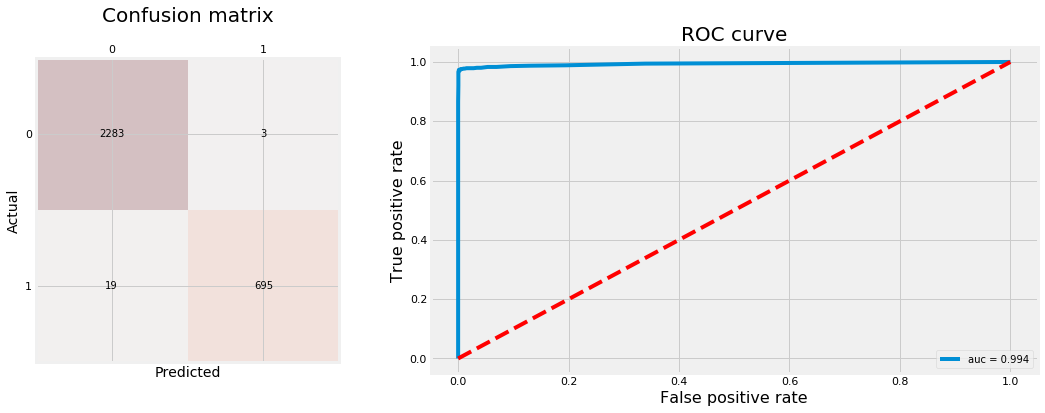

In [89]:
## Refit Rf classifier using best params
clf_rf = make_pipeline(StandardScaler(),
                       RandomForestClassifier(n_estimators=50,
                                              criterion='entropy',
                                              max_features=0.4,
                                              min_samples_leaf=1,
                                              class_weight='balanced',
                                              n_jobs=-1,
                                              random_state=123)                                             
                      )
clf_rf.fit(X_train, y_train)

# Plot confusion matrix & ROC curve
plot_conf_matrix_and_roc(clf_rf, X_test, y_test)

<a style='color:black; font-weight:bold' name='mod4'>
Gradient Boosting Trees</a>

The two other hyperparameters other than `max_features` and `n_estimators` that we're going to tune are:

- `learning_rate`: rate the tree learns, the slower the better.
- `max_depth`: number of split each time a tree is growing which limits the number of nodes in each tree.

In [90]:
## Build Gradient Boosting Classifier
pip_gb = make_pipeline(StandardScaler(),
                       GradientBoostingClassifier(loss='deviance',
                                                  random_state=123)
                      )

hyperparam_grid = {'gradientboostingclassifier__max_features': ['log2', 0.5],
                   'gradientboostingclassifier__n_estimators': [100,300,500],
                   'gradientboostingclassifier__learning_rate': [0.001, 0.01, 0.1],
                   'gradientboostingclassifier__max_depth': [1,2,3]
                  }

gs_gb = GridSearchCV(pip_gb,
                     param_grid=hyperparam_grid,
                     scoring='f1',
                     cv=10,
                     n_jobs=-1
                    )
gs_gb.fit(X_train, y_train)

print_mod_10fold_CV_f1_score(gs_gb)

The best hyperparameters:
-------------------------
learning_rate :  0.1
max_depth :  3
max_features :  0.5
n_estimators :  500
Best 10-folds CV f1-score: 97.88%.



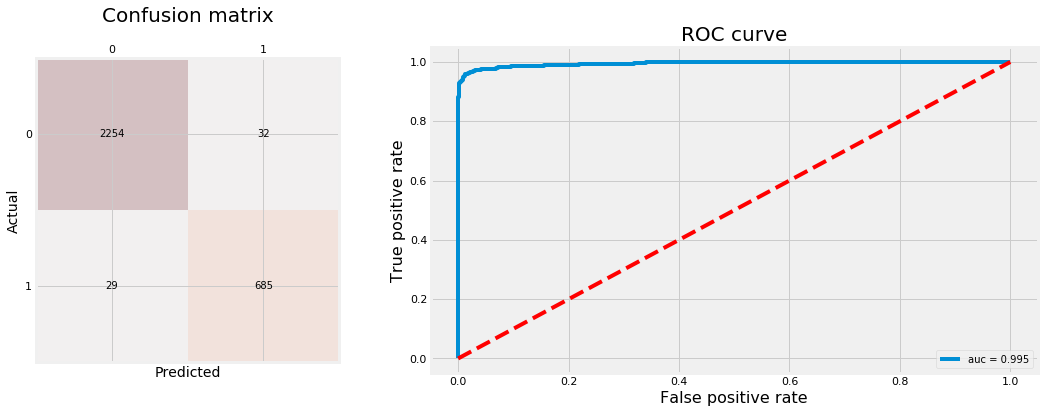

In [91]:
## Plot confusion matrix and ROC curve
plot_conf_matrix_and_roc(gs_gb, X_test, y_test)

<a style='color:black; font-weight:bold' name='mod5'>
K-Nearest Neighbors </a>

The two hyperparameters we're going to tune are:
- `n_neighbors`: number of neighbors to use in prediction.
- `weights`: how much weight to assign neighbors based on:
    - "uniform": all neighboring points have the same weight.
    - "distance": use the inverse of euclidean distance of each neighboring point used in prediction.

In [92]:
# Build KNN Classifier
pip_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
hyperparam_range = range(1, 20)

gs_knn = GridSearchCV(pip_knn,
                      param_grid={'kneighborsclassifier__n_neighbors': hyperparam_range,
                                  'kneighborsclassifier__weights': ['uniform', 'distance']
                                 },
                      scoring='f1',
                      cv=10,
                      n_jobs=-1
                     )
gs_knn.fit(X_train, y_train)

print_mod_10fold_CV_f1_score(gs_knn)

The best hyperparameters:
-------------------------
n_neighbors :  1
weights :  uniform
Best 10-folds CV f1-score: 98.24%.



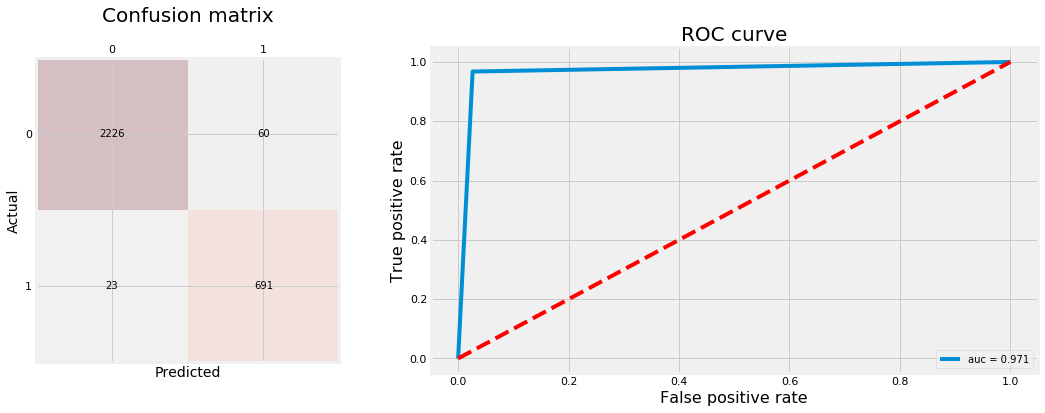

In [93]:
plot_conf_matrix_and_roc(gs_knn, X_test, y_test)

<a style='color:black; font-weight:bold' name='mod6'>
Logistic Regression </a>

For logistic regression, we'll tune three hyperparameters:
- `penalty`: type of regularization, L2 or L1 regularization.
- `C`: the opposite of regularization of parameter $\lambda$. The higher C the less regularization. We'll use values that cover the full range between unregularized to fully regularized where model is the mode of the examples' label.
- `fit_intercept`: whether to include intercept or not.

We won't use any non-linearities such as polynomial features.

In [94]:
## Bulid logistic model classifier
pip_logmod = make_pipeline(StandardScaler(),
                           LogisticRegression(class_weight='balanced')
                          )
hyperparam_range = np.arange(0.5,20.1, 0.5)
hyperparam_grid = {'logisticregression__penalty': ['l1','l2'],
                   'logisticregression__C': hyperparam_range,
                   'logisticregression__fit_intercept': [True, False]
                  }
gs_logmodel = GridSearchCV(pip_logmod,
                           hyperparam_grid,
                           scoring='accuracy',
                           cv=2,
                           n_jobs=-1
                          )
gs_logmodel.fit(X_train, y_train)

print_mod_10fold_CV_f1_score(gs_logmodel)      

The best hyperparameters:
-------------------------
C :  1.0
fit_intercept :  True
penalty :  l1
Best 10-folds CV f1-score: 77.20%.



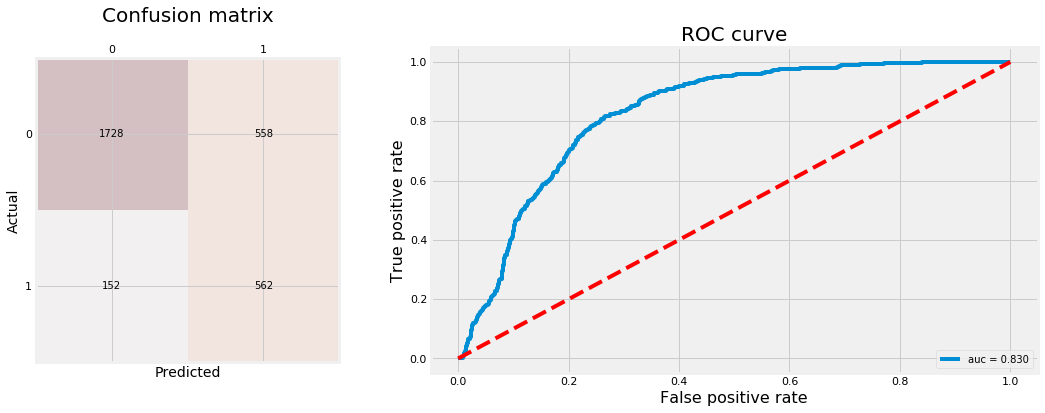

In [95]:
plot_conf_matrix_and_roc(gs_logmodel, X_test, y_test)

<a style='color:black; font-weight:bold' name='mod7'>
Support Vector Machine (SVM) </a>

SVM is comutationally very expensive to tune it's hyperparameters for two reasons:
1. With big datasets, it becomes very slow.
2. It has good number of hyperparameters to tune that takes very long time to tune on a CPU.

Therefore, we'll use recommended hyperparameters' values from the paper we mentioned before that showed to yield the best performane on Penn Machine Learning Benchmark 165 datasets. The hyperparameters that we usually look to tune are:
- `C`, `gamma`, `kernel`, `degree` and `coef0`

In [96]:
## Build SVM classifier
clf_svc = make_pipeline(StandardScaler(),
                        SVC(C=0.01,
                            gamma=0.1,
                            kernel='poly',
                            degree=5,
                            coef0=10,
                            probability=True)
                       )
clf_svc.fit(X_train, y_train)

svc_cv_scores = cross_val_score(clf_svc,
                                X=X_train,
                                y=y_train,
                                scoring='f1',
                                cv=10,
                                n_jobs=-1
                               )

print("\033[1m" + "\033[94m" + 
      "The 10-folds CV f1-score is: {:.2f}%".format(
       np.mean(svc_cv_scores) * 100))

The 10-folds CV f1-score is: 96.38%


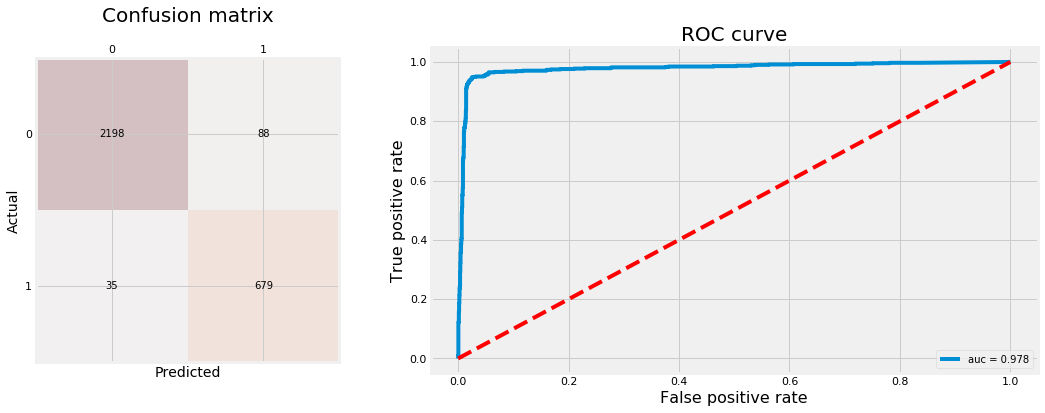

In [97]:
plot_conf_matrix_and_roc(clf_svc, X_test, y_test)

<div style="width:610px;background:#fdf0db;border:1px solid black;
  text-align:left;padding:8px;"><b>
<h7><a name='mod8'><font color=black>Evaluating Model Results
    </a></h7></b>    
</div>

Let us Plot the ROC Curves for all classifiers and compare the <br>`Accuracy Rate`, `f1-score`, and `AUC`.

The accuracy rate and f1-score on test data are:
RF: 99.27%, 98.44%.
LR: 76.33%, 61.29%.
SVM: 95.90%, 91.69%.
GBT: 97.97%, 95.74%.
KNN: 97.23%, 94.33%.


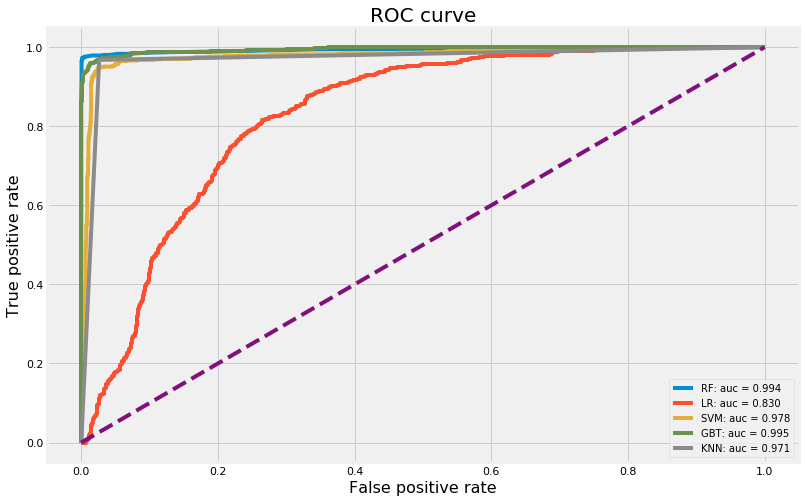

In [98]:
## Plot ROC curves for all classifiers
estimators = {'RF' : clf_rf,
              'LR' : gs_logmodel,
              'SVM': clf_svc,
              'GBT': gs_gb,
              'KNN': gs_knn
             }
plot_roc(estimators, X_test, y_test, (12,8))

## Print Accuracy Score of each model
print("The accuracy rate and f1-score on test data are:")
for estimator in estimators.keys():
    print("{}: {:.2f}%, {:.2f}%.".format(estimator,
        accuracy_score(y_test, estimators[estimator].predict(X_test)) * 100,
         f1_score(y_test, estimators[estimator].predict(X_test)) * 100))

In [99]:
comments='''
Even though Random Forest and Gradient Boosting Trees have 
almost equal auc (.994 vs .995 respectively), Random Forest 
has higher accuracy rate and an f1-score with 99.27% and 98.44% 
respectively. 

Therefore, we safely say Random Forest outperforms the rest 
of the classifiers.
'''

<a style='color:black; font-weight:bold' name='udf1'>
Random Forest Classifier Important Features </a>

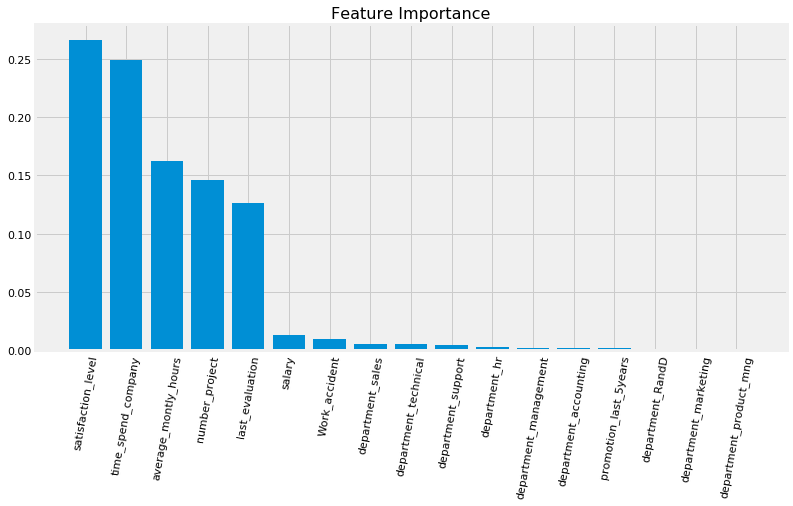

In [100]:
clf_rf = RandomForestClassifier(n_estimators=50,
                                criterion='entropy',
                                max_features=0.4,
                                min_samples_leaf=1,
                                class_weight='balanced',
                                n_jobs=-1,
                                random_state=123)
clf_rf.fit(StandardScaler().fit_transform(X_train),y_train)

# Plot features importance
importances = clf_rf.feature_importances_
indices = np.argsort(clf_rf.feature_importances_)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, 18), importances[indices], align="center")
plt.xticks(range(1, 18), df.columns[df.columns != "left"][indices], rotation=800)
plt.title("Feature Importance", {"fontsize": 16});

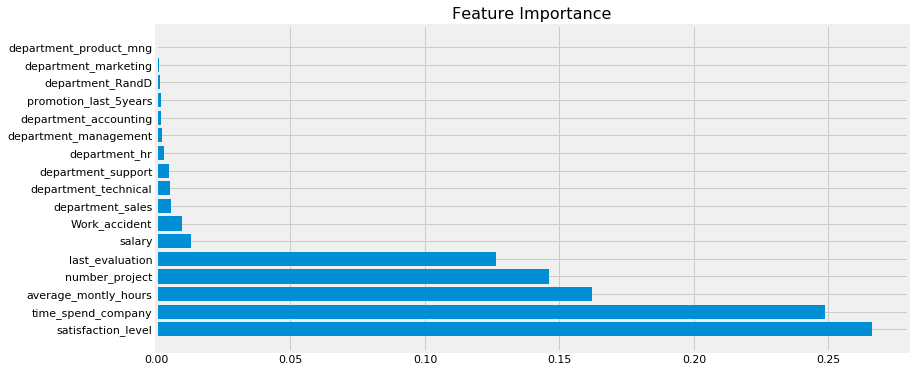

In [101]:
## same as above but we will use a horizontal bargraph...
importances = clf_rf.feature_importances_
indices = np.argsort(clf_rf.feature_importances_)[::-1]
plt.figure(figsize=(12, 6))
plt.barh(range(1, 18),importances[indices])
plt.yticks(range(1, 18), df.columns[df.columns != "left"][indices] )
plt.title("Feature Importance", {"fontsize": 16});

Based on the graphs above, the five most important features are
- satisfaction_level
- time_spend_company
- average_montly_hours
- number_project
- last_evaluation

<div style="width:610px;background:#fdf0db;border:1px solid black;
  text-align:left;padding:8px;"><b>
<h7><a name='summary'><font color=black>Summary & Conclusion
    </a></h7></b>    
</div>

- For imbalanced classes, accuracy is not a good method to evaluate your models.  AUC & F1-Score are the preferred metrics to use.
- Upsampling/downsampling are good methods to improve accuracy of classifier for imbalanced classes datasets
- For this dataset, we have determined that the best classifier model is Random Forest using Upsampling Method.